# SST1 NEXAFS Processing Notebook

Takes raw SST1 output (folders & primary.csv's) and can plot/export:
* Normalized NEXAFS data for each measured angle
* Extrapolated NEXAFS to total isotropy anisotropy (applicable only to uniaxial samples)
* Binary contrasts in a variety of data formats (animated gif)
* CyRSoXS materials.txt files

In [3]:
### Imports:
import kkcalc, pathlib, json, os
from kkcalc import data
from kkcalc import kk
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy import optimize

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [4]:
### Functions: 

# These use timestamps in the various files to interpolate/bin signals onto energy
def read_NEXAFS(scan_num,base,detector='WAXS'):
    mesh = pd.read_csv(list(pathlib.Path(base,scan_num).glob('*Au Mesh*.csv'))[0])
    sample_current = pd.read_csv(list(pathlib.Path(base,scan_num).glob('*Sample Current*.csv'))[0])
    primary = pd.read_csv(list(base.glob(scan_num + '*primary.csv'))[0])
    beamstop = pd.read_csv(list(pathlib.Path(base,scan_num).glob(f'*{detector}*monitor.csv'))[0])
    return primary, mesh, sample_current, beamstop

def interp_NEXAFS(primary, mesh, sample, beamstop,detector='WAXS'):
    mesh_interp = np.interp(primary['time'],mesh['time'],mesh['RSoXS Au Mesh Current'])
    sample_interp = np.interp(primary['time'],sample['time'],sample['RSoXS Sample Current'])
    beamstop_interp = np.interp(primary['time'],beamstop['time'],beamstop[f'{detector} Beamstop'])
    return mesh_interp, sample_interp, beamstop_interp

def read_interp(scan_num, base, detector='WAXS'):
    # print(f'{detector} detector selected')
    primary, mesh, sample_current, beamstop = read_NEXAFS(scan_num, base, detector=detector)
    energy = primary['en_monoen_readback']
    mesh_interp, sample_interp, beamstop_interp = interp_NEXAFS(primary, mesh, sample_current, beamstop, detector=detector)
    return energy, mesh_interp, sample_interp, beamstop_interp

def get_pol(scan_num, base):
    """
    Returns polarization and sample polarization for selected scan number in specificed path. 
    """
    abs_pol = round(pd.read_csv(list(base.joinpath(scan_num).glob('*baseline*'))[0])['en_polarization'][0], 0)
    sample_pol = round(pd.read_csv(list(base.joinpath(scan_num).glob('*baseline*'))[0])['en_sample_polarization'][0], 0) 
    return abs_pol, sample_pol

def get_name(scan_num, base):
    loaded_json = json.load(open((list(pathlib.Path(base, scan_num).glob('*json*')))[0], 'r'))
    name = loaded_json[1]['sample_name']
    return name

def list_files(path, out='names', glob='*'):
    """
    Input: pathlib filepath object
           type of output (out = 'names' or out = 'files')
           glob str selector (default is '*')
    Output: returns list of either filenames of filepaths depending on output selected
    """
    files = sorted(path.glob(glob))
    filenames = [file.name for file in files]
    if out=='names':
        return filenames
    elif out=='files':
        return files
    else:
        print('No output selected, choose "names" or "files"')

In [5]:
### Define relevant directories here:
# Recommended to check you did this right by using the "exists()" path method, (e.g. notebookPath.exists())

notebookPath = pathlib.Path.cwd()
exportPath = notebookPath.joinpath('normed_nexafs')
rootPath = notebookPath.parent.parent
samplePath = rootPath.joinpath('beamline_data', 'BNL-RSoXS-Jul2022', 'rsoxs', 'nexafs_raw')
calibPath = samplePath.parent.joinpath('calibration_2022-08-01')

In [6]:
# Define a dictionary for names if necessary
namesdict = {
    'nexafs1':'PM6',
    'nexafs2':'PM7D5',
    'nexafs3':'Y6',
    'nexafs4':'Y12',
    'nexafs5':'Y7',
    'nexafs6':'Y7BO',
    'nexafs7':'Y247'
}

## Normalize raw data & output txt file for next steps

In [6]:
sample_name = 'nexafs3' # Select which sample you want to plot first

scan_nums = [name[:5] for name in list_files(samplePath, glob=f'*{sample_name}*')]  # List scan numbers for selected sample
diode_nums = [name[:5] for name in list_files(calibPath, glob='*313*diode*.csv')]  # Select appropriate diode scans

In [7]:
energy = np.linspace(281, 340, 400)

sample_data = {'energy':energy}
diode_data = {'energy':energy}
pols = []
spols = []
dpols = []

for i in range(len(scan_nums)):
    # Name the scan numbers
    scan_num = scan_nums[i]
    diode_num = diode_nums[i]
    
    # Get polarizations for sample + diode
    pol, s_pol = get_pol(scan_num, samplePath)
    diode_pol, diode_s_pol = get_pol(diode_num, calibPath)
    
    # Readout measurement data
    sample_energy, mesh, sample, beamstop = read_interp(scan_num, samplePath, detector='SAXS')
    diode_energy, diode_mesh, diode_sample, diode_beamstop = read_interp(diode_num, calibPath, detector='SAXS')
    
    # Interp measured data onto selected energy range outside of this loop 
    mesh = np.interp(energy, sample_energy, mesh)
    sample = np.interp(energy, sample_energy, sample)
    beamstop = np.interp(energy, sample_energy, beamstop)
    
    diode_mesh = np.interp(energy, diode_energy, diode_mesh)
    diode_sample = np.interp(energy, diode_energy, diode_sample)
    diode_beamstop = np.interp(energy, diode_energy, diode_beamstop)
    
    # Write into appropriate dict, also record all polarizations
    pols.append(round(pol))
    spols.append(round(s_pol))
    dpols.append(round(diode_s_pol))
    sample_data[round(s_pol)] = [mesh, sample, beamstop]
    diode_data[round(diode_s_pol)] = [diode_mesh, diode_sample, diode_beamstop]


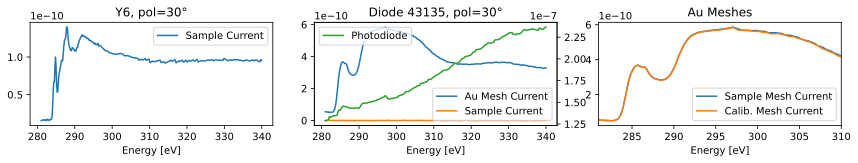

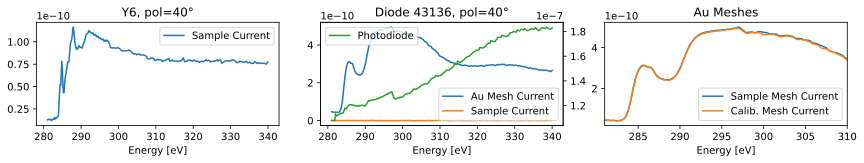

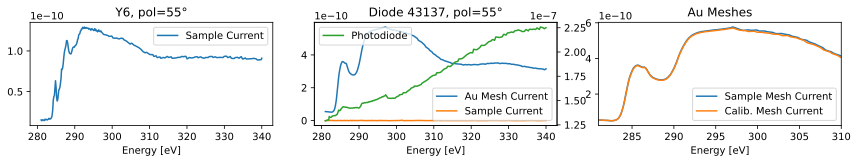

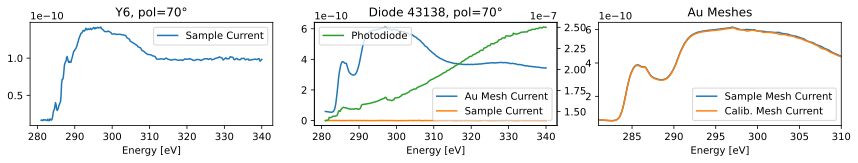

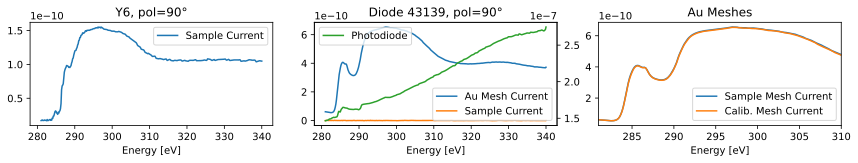

In [8]:
for i in range(len(scan_nums)):
    spol = spols[i]
    dpol = dpols[i]
    pol = pols[i]
    diode_num = diode_nums[i]
    
    fig, (sample_ax1, diode_ax1, mesh_ax) = plt.subplots(1,3)
    fig.set(size_inches=(12,2), dpi=50)
    fig.tight_layout()
    
    sample_ax1.set(title=f'{namesdict[sample_name]}, pol={spol}°', xlabel='Energy [eV]')
    sample_ax1.plot(sample_data['energy'], sample_data[spol][1], label='Sample Current')
    sample_ax1.legend()
    
    diode_ax1.set(title=f'Diode {diode_num}, pol={dpol}°', xlabel='Energy [eV]')
    diode_ax1.plot(diode_data['energy'], diode_data[dpol][0], label='Au Mesh Current')
    diode_ax1.plot(diode_data['energy'], diode_data[dpol][1], label='Sample Current')
    diode_ax1.legend(loc='lower right')
    diode_ax2 = diode_ax1.twinx()
    diode_ax2.plot(diode_data['energy'], diode_data[dpol][2], color='tab:green', label='Photodiode')
    diode_ax2.legend(loc='upper left')
    
    mesh_ax.set(title=f'Au Meshes', xlim=(281, 310), xlabel='Energy [eV]')
    mesh_ax.plot(sample_data['energy'], sample_data[spol][0], label='Sample Mesh Current')
    mesh_ax.plot(diode_data['energy'], diode_data[dpol][0], label="Calib. Mesh Current")
    mesh_ax.legend()
    

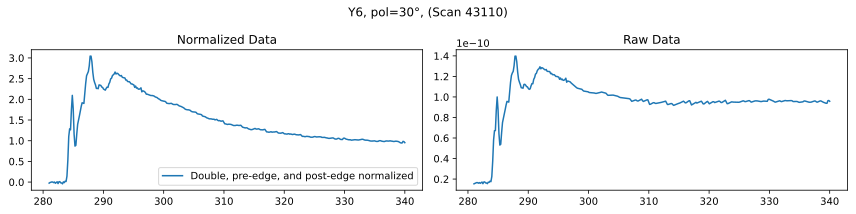

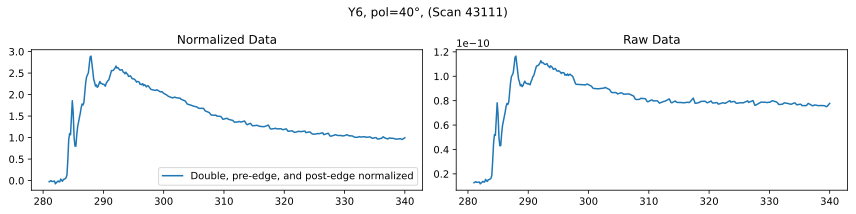

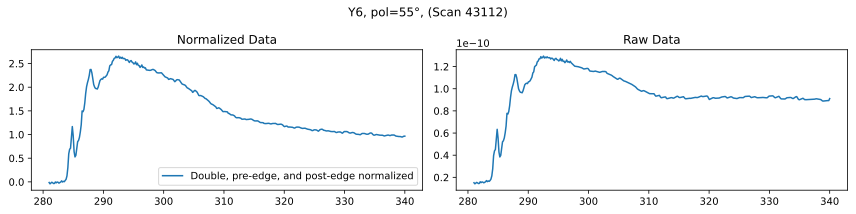

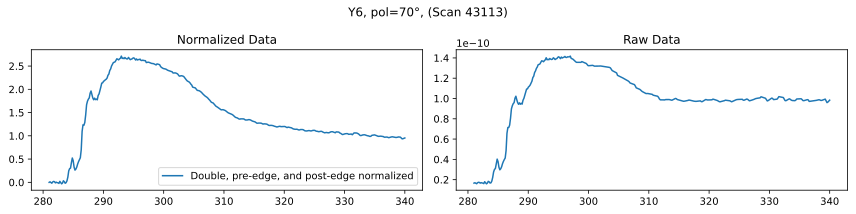

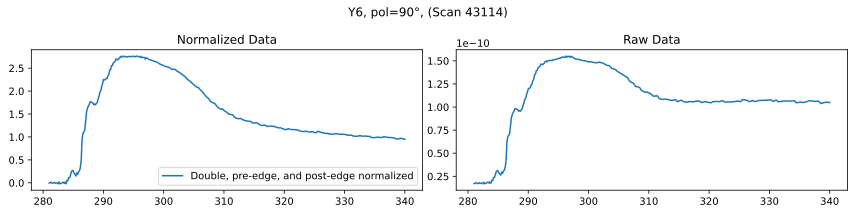

In [9]:
# Normalization cell

sample_data_normed = {'energy':energy}

for i in range(len(scan_nums)):
    spol = spols[i]
    dpol = dpols[i]
    scan_num = scan_nums[i]
    diode_num = diode_nums[i]
    
    diode_mesh = diode_data[dpol][0]
    diode_beamstop = diode_data[dpol][2]
    sample = sample_data[spol][1]
    mesh = sample_data[spol][0]
    
    # Calculate double normalization factor from diode scan
    double_norm = diode_mesh/diode_beamstop
    dnormed_data = (sample/mesh)*double_norm
    
    # Pre and post edge normalizations:
    pre_energy = energy[energy<284]
    pre_intensity = dnormed_data[energy<284]
    pre_mean = np.mean(pre_intensity)
    dnormed_data_pre = dnormed_data-pre_mean

    post_energy = energy[energy>330]
    post_intensity = dnormed_data_pre[energy>330]
    post_mean = np.mean(post_intensity)
    dnormed_data_pre_post = dnormed_data_pre/post_mean
    
    # Write data to above dictionary:
    sample_data_normed[spol] = dnormed_data_pre_post
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle(f'{namesdict[sample_name]}, pol={spol}°, (Scan {scan_num})')
    ax1.plot(energy, dnormed_data_pre_post, label='Double, pre-edge, and post-edge normalized')
    ax1.legend(loc='lower right')
    ax1.set_title('Normalized Data')
    # ax1.set(xlim=(280,284))
    ax2.plot(energy, sample)
    ax2.set_title('Raw Data')
    fig.set(size_inches=(12,3), dpi=100)
    fig.tight_layout()
    plt.show()

In [10]:
# Save normed data as txt file 

df = pd.DataFrame(sample_data_normed)
display(df)
# np.savetxt(exportPath.joinpath(f'{namesdict[sample_name]}_normed_nexafs.txt'), df)

,energy,30,40,55,70,90
0,281.000000,-0.025015,-0.027451,-0.012883,-0.000643,-0.007899
1,281.147870,-0.010514,-0.013689,-0.041021,0.010813,0.002997
2,281.295739,-0.004951,0.000073,-0.023714,-0.004052,0.014758
3,281.443609,0.003335,-0.019461,-0.007445,-0.018481,-0.006734
4,281.591479,0.001831,-0.020834,-0.018488,0.007420,-0.007607
...,...,...,...,...,...,...
395,339.408521,0.945299,0.964371,0.951133,0.952291,0.970812
396,339.556391,0.945764,0.956149,0.946239,0.933920,0.966108
397,339.704261,0.984550,0.968995,0.955947,0.938297,0.959475
398,339.852130,0.977757,0.982847,0.965656,0.946299,0.952882


## Next steps

In [169]:
### Functions:

def load_nexafs(fpath, angles, samplename):
    """
    Returns xarray dataset of loaded nexafs data formatted properly for rest of workflow. 
    
    Inputs: filepath to *.txt file with columns of energy, angle1, angle2, etc. 
            angles (np array of angles in column order)
    Outputs: properly formatted xarray dataset of data
    """
    tey= np.loadtxt(fpath).T

    #wrap in an xarray
    θ_val = angles

    nexafs = xr.Dataset(
        data_vars=dict(electron_yield=(['cos_sq_θ', 'energy'], tey[1:])),
        coords={'cos_sq_θ': np.cos(θ_val*np.pi/180)**2, 'θ': ('cos_sq_θ', θ_val), 'energy' : tey[0]},
        attrs=dict(description=f'{samplename} Normalized NEXAFS', name=samplename),
    )
    nexafs.energy.attrs['unit'] = 'eV'
    nexafs['electron_yield'].attrs['unit'] = 'a.u.'
    nexafs['θ'].attrs['unit'] = '°'
    
    return nexafs

def show_nexafs(xmin, xmax, nexafs, save=False, savename=None, exportPath=exportPath, sample=sample):
    """
    Plots loaded nexafs xarray dataset over specificed energy. 
    Option to save figure:
        Default savename is: '{sample}_normed_nexafs_{xmin}-{xmax}.svg')
        Can be chosen by setting savename. 
        Default to save into path called "exportPath", also can be chosen differently.
    """
    fig, ax1 = plt.subplots()
    #the xarray way of plotting
    colors = plt.cm.viridis(np.linspace(0,0.8,nexafs.θ.size))

    for i, cos_sq_θ in enumerate(nexafs.cos_sq_θ): 
        nexafs.electron_yield.sel(cos_sq_θ=cos_sq_θ).plot(color=colors[i], label = f'{nexafs.θ.values[i]}°', ax=ax1)
    plt.title(nexafs.description)
    ax1.set_xlim(xmin,xmax)
    ax1.legend()
    if save==True:
        if savename==None:
            plt.savefig(exportPath.joinpath(f'{sample}_normed_nexafs_{xmin}-{xmax}.svg'))
        elif savename:
            plt.savefig(exportPath.joinpath(savename))
    plt.show()
    
def i_nexafs(α, θ):
    """
    Stöhr equation 9.16a:
    
    Inputs: α and θ
    Outputs: Calculated intensity value (arbitrary units)
    """
    return (1/3)*(1+0.5*(3*(np.cos(θ*np.pi/180))**2-1)*(3*(np.cos(α*np.pi/180))**2-1))

def int_area(e_min, e_max, nexafs):
    """
    Integrates selected regions in nexafs data
    """
    #make only positive:
    return nexafs.sel(energy = slice(e_min,e_max)).integrate('energy').electron_yield.values

In [190]:
sample='Y6'
nexafs = load_nexafs(exportPath.joinpath(f'{sample}_normed_nexafs.txt'), np.array([30,40,55,70,90]), sample)

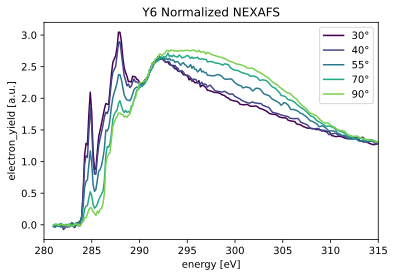

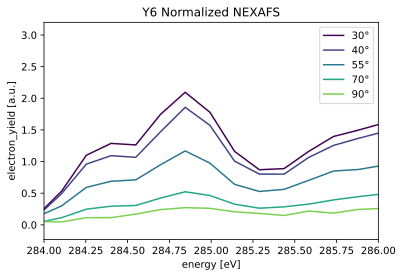

In [191]:
show_nexafs(280, 315, nexafs, save=False)
show_nexafs(284, 286, nexafs, save=False)

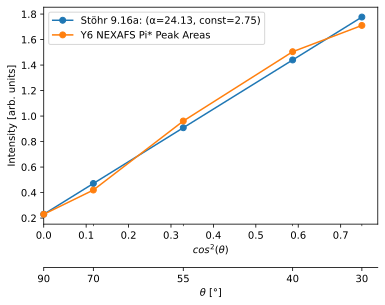

     fun: 0.013933507717060414
 message: 'Optimization terminated successfully.'
    nfev: 933
     nit: 30
 success: True
       x: array([24.13267923,  2.75232357])

In [192]:
res = run_tilt_fit(283.5, 285.3, nexafs)
res

A hasty line fit shown below. Note rather than fitting peaks, I'm cheating by integrating the whole asorbance at the lower-energy side of the pi* manifold. This is a common trick when evaluating and manipulating pi* resonances because there are few other contributors to absorbance in this energy range. Best practice in NEXAFS analysis is to fit a system of peaks to the data and evaluate the orientation of the peaks separately.

In [13]:
# results_dict = {}

In [52]:
e_min = 284
e_max = 286
pi_peak_areas =  int_area(e_min, e_max, nexafs)
θ_list = nexafs['θ'].values

def mse_line(my_vars, pi_peak_areas, θ_list):
    α = my_vars[0]
    const = my_vars[1]
    return ((const*i_nexafs(α, θ_list)-pi_peak_areas)**2).sum()

bnds= [(0,90),(0,10)]
res = optimize.differential_evolution(mse_line, bounds=bnds, args = (pi_peak_areas, θ_list), tol=1e-6)
print(res)

results_dict[sample] = np.round(res.x, 2)

     fun: 0.0032339949494709004
 message: 'Optimization terminated successfully.'
    nfev: 933
     nit: 30
 success: True
       x: array([34.38109094,  4.14224432])


In [15]:
alpha, const = res.x

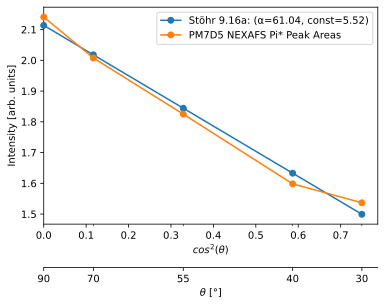

In [16]:
fig, ax = plt.subplots()
ax.plot(nexafs.cos_sq_θ.values[:], const*i_nexafs(alpha, nexafs.θ.values[:]), marker='o', label=f'Stöhr 9.16a: (α={np.round(alpha,2)}, const={np.round(const,2)})', clip_on=False, zorder=3)
ax.plot(nexafs.cos_sq_θ.values[:], pi_peak_areas[:], marker='o', label=f'{sample} NEXAFS Pi* Peak Areas', clip_on=False, zorder=4)
ax.set(xlabel=r'$cos^2(\theta)$', ylabel='Intensity [arb. units]')
ax.set_xticks(nexafs.cos_sq_θ.values, minor=True)
ax.set_xlim(left=0)
ax.legend()

def forward(x):
    # print(x)
    return np.arccos(np.sqrt(x))*180/np.pi

def inverse(x):
    return np.cos(x*np.pi/180)**2

ax2 = ax.secondary_xaxis(-0.2, functions=(forward, inverse))
ax2.set(xlabel=r'$\theta$ '+'$[\degree]$')
ax2.set_xticks(nexafs.θ.values)

plt.show()

In [53]:
# df = pd.DataFrame.from_dict(results_dict, orient='index', columns=('α', 'constant'))
# df.index.name = 'Sample'
# # df.to_csv('tilt_angle_fit_results.csv')
# df

In [306]:
# pd.read_csv('tilt_angle_fit_results.csv').set_index('Sample')

## Dielectric function of the measured Y6 NEXAFS

Below is a wrapped kkcalc function similar to what we used in Part 1. This wrapped function accepts an xarray of nexafs labeled as above, and creates a temporary *.txt file from it. This is a workaround to kkcalc's need to have a text file on disk as the input. Future versions of kkcalc may accept array arguments directly. 

In [70]:
def run_kkcalc(nexafs_xr, x_min = 280, x_max = 340, chemical_formula = 'C82H86F4N8O2S5', density = 1.1):

    #save xarray as disposable text file 'scratch_nexafs.txt'
    np.savetxt('scratch_nexafs.txt',  np.c_[nexafs_xr.energy.values, nexafs_xr.electron_yield.values])

    # The output of kk.kk_calculate_real is f1 and f2 terms since they are calculated using Kramers-Kronig transform
    
    output = kk.kk_calculate_real('scratch_nexafs.txt',
                                  chemical_formula,
                                  load_options=None,
                                  input_data_type='Beta',
                                  merge_points=[x_min, x_max],
                                  add_background=False,
                                  fix_distortions=False,
                                  curve_tolerance=None,
                                  curve_recursion=100)

    # Fitting to the Henke atomic scattering factors using the given stoichiometry and formula
    stoichiometry = kk.data.ParseChemicalFormula(chemical_formula)
    formula_mass = data.calculate_FormulaMass(stoichiometry)
    ASF_E, ASF_Data = kk.data.calculate_asf(stoichiometry)
    ASF_Data2 = kk.data.coeffs_to_ASF(ASF_E, np.vstack((ASF_Data, ASF_Data[-1])))
    # Conversion to delta and beta and making an xarray
    n = xr.Dataset({
        'δ':(['energy'],data.convert_data(output[:,[0,1]],'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)[:,1]), 
        'β':(['energy'],data.convert_data(output[:,[0,2]],'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)[:,1])},
        coords={'energy': data.convert_data(output[:,[0,1]],'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)[:,0]})

    n.energy.attrs['unit'] = 'eV'
    n.δ.attrs['unit'] = 'a.u.'
    n.β.attrs['unit'] = 'a.u.'
    
    os.remove('scratch_nexafs.txt')
    return n #return an xarray

A version of the wrapped function that accepts and handles xarray with a 'cos_sq_θ' axis:

In [175]:
#wrap a function to run kkcalc on an xarray containing a cos_sq_θ dimension
def run_kkcalc_a(nexafs_xr, x_min = 280, x_max = 340, chemical_formula = 'C82H86F4N8O2S5', density = 1.1):
    n = []
    for cos_sq_θ in nexafs_xr.cos_sq_θ:
        n.append(run_kkcalc(nexafs_xr.sel(cos_sq_θ=cos_sq_θ), x_min = x_min, x_max = x_max, chemical_formula = chemical_formula, density = density))
    n = xr.concat(n, dim=nexafs_xr.cos_sq_θ)
    n.assign_coords(θ=('cos_sq_θ', nexafs_xr.θ.values))
    n.attrs['name'] = nexafs_xr.name
    return n

In [193]:
#formula should be correct for Y6. density is a guess.
n = run_kkcalc_a(nexafs, x_min = 280, x_max = 315, chemical_formula = 'C82H86F4N8O2S5', density = 1.1)

In [87]:
#wrap a function to plot δ and β for an angle collection series
def show_diel(xmin, xmax, n, save=False, savename=None):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set(size_inches=(8,8))
    fig.suptitle(f'{n.name} dielectric functions')
    
    colors = plt.cm.viridis(np.linspace(0,0.8,n.cos_sq_θ.size))
    colors2 = plt.cm.plasma(np.linspace(0,0.8,n.cos_sq_θ.size))

    for i, cos_sq_θ in enumerate(n.cos_sq_θ): 
        n.δ.sel(cos_sq_θ=cos_sq_θ).plot(ax =ax1, color = colors[i], lw = 2, label = f'{n.θ[i].values}°')
        n.β.sel(cos_sq_θ=cos_sq_θ).plot(ax =ax2, color = colors2[i], lw = 2, label = f'{n.θ[i].values}°')

    #note it is also possible to plot without an iterator using xarray's multidimensional "hue" argument as shown below, but the above allows me more control over the colors & labels. 
    #n.δ.plot(ax=ax1, hue='angle')

    ymin1 =n.δ.sel(energy=slice(xmin,xmax)).min()
    ymax1 = n.δ.sel(energy=slice(xmin,xmax)).max()
    ax1.set_xlim(xmin, xmax)
    ax1.set_xlabel('')
    ax1.set_ylim(ymin1 - (ymax1-ymin1)*0.03, ymax1 + (ymax1-ymin1)*0.03)
    ax1.legend(loc ='lower right')
    ax1.set_title('δ')

    ymax2 = n.β.sel(energy=slice(xmin,xmax)).max()

    ax2.legend(loc='upper right')
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(0, ymax2 + (ymax2)*0.03)
    ax2.set_title('β')
    plt.setp(ax1.get_xticklabels(), visible=False)
    
    if save==True:
        if savename==None:
            plt.savefig(f'{sample}_difxns.svg')
        elif savename:
            plt.savefig(savename)
    
    plt.show()

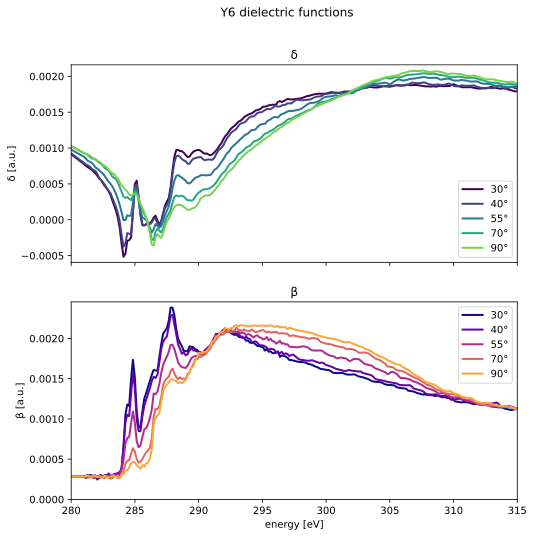

In [194]:
show_diel(280, 315, n)

This dielectric function, pretty though it is, still isn't sufficient even to describe the unaxial function of the measured NEXAFS. That is because the extraordinary part of the dielectric function could only be measured by the NEXAFS measurement at $\theta=0$°. There is no experimental geometry that allows $\theta=0$°, so it must be extrapolated.

Intensity should be linear with $cos^2\theta$, so we will fit the nexafs xarray to it. The below xr.polyfit function creates a linear fit function <em>at every energy</em> in the nexafs curve.

In [195]:
nexafs_fit = nexafs.electron_yield.polyfit('cos_sq_θ', 1)
# new_θ = np.array([0, 30, 40, 55, 70, 90])
# new_cos_sq_θ = (np.cos(new_θ*np.pi/180))**2
# nexafs_ep = evaluate_nexafs_fit(nexafs, nexafs_fit, new_cos_sq_θ, new_θ)

Now that we have a fit at every energy, we'd like to evaluate it. The current xarray implementation of xr.polyval is 'clunky,' to put it mildly.<br>
This function wraps the polyval evaluation and returns a clean nexafs dataset with appropriate metadata. This may be updated or replaced for future versions of xarray.<br>
<ul>nexafs is the original nexafs dataset<br>
nexafs_fit is returned from the polyfit as above<br>
new_cos_sq_θ is an array-like argument of cos_sq_θ values where you want the fit to be evaluated<br>
new_θ is an array-like argument of θ values to assign to those results<br></ul>

In [124]:
def evaluate_nexafs_fit(nexafs, nexafs_fit, new_cos_sq_θ, new_θ):
    nexafs_dummy = xr.Dataset(
        data_vars=dict(electron_yield=(['cos_sq_θ'], new_cos_sq_θ)),
        coords={'cos_sq_θ': new_cos_sq_θ},
        attrs=dict(description='Y6 NEXAFS', name=nexafs.name),
    )
    
    #nexafs_dummy = xr.DataArray(data=new_cos_sq_θ, dims = ['cos_sq_θ'], coords = {'cos_sq_θ':new_cos_sq_θ})

    #this returns an xarray but it is unlabeled and has little of the structure, labels of the original one that was fit.
    nexafs_ep =  xr.polyval(nexafs_dummy.cos_sq_θ, nexafs_fit.polyfit_coefficients)

    
    # I re-form it into a good dataset here by resorting to .values
    nexafs_ep = xr.Dataset(
        data_vars=dict(
        electron_yield=(['cos_sq_θ', 'energy'], nexafs_ep.values)),
        coords={'cos_sq_θ': new_cos_sq_θ, 'θ': ('cos_sq_θ', new_θ), 'energy' : nexafs_ep.energy},
        attrs=dict(description=nexafs.description, name=nexafs.name),
    )
    nexafs_ep.energy.attrs['unit'] = 'eV'
    nexafs_ep['electron_yield'].attrs['unit'] = 'a.u.'
    nexafs_ep['θ'].attrs['unit'] = '°'
    return nexafs_ep

In [196]:
new_θ = np.array([0, 30, 40, 55, 70, 90])
new_cos_sq_θ = (np.cos(new_θ*np.pi/180))**2
nexafs_ep = evaluate_nexafs_fit(nexafs, nexafs_fit, new_cos_sq_θ, new_θ)

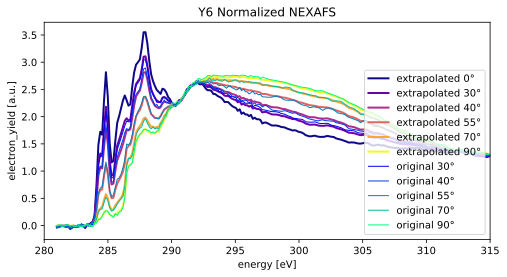

In [199]:
fig, ax1 = plt.subplots(figsize=(8,4))
#the xarray way of plotting
colors = plt.cm.plasma(np.linspace(0,1,nexafs_ep.θ.size))
colors2 = plt.cm.winter(np.linspace(0,1,nexafs.θ.size))
for i, cos_sq_θ in enumerate(nexafs_ep.cos_sq_θ): 
    nexafs_ep.electron_yield.sel(cos_sq_θ=cos_sq_θ).plot(color = colors[i], lw = 2, label = f'extrapolated {nexafs_ep.θ[i].values}°')
for i, cos_sq_θ in enumerate(nexafs.cos_sq_θ): 
    nexafs.electron_yield.sel(cos_sq_θ=cos_sq_θ).plot(color = colors2[i], lw = 1, label = f'original {nexafs.θ[i].values}°')
plt.title(nexafs.description)
ax1.set_xlim(280,315)
ax1.legend(loc='lower right')
plt.savefig(exportPath.joinpath(f'{nexafs_ep.name}_nexafs_theta_extrap.svg'))
plt.show()

Note that the extrapolated 90° is very close by the original 90° (this is good. it should be identical), and the extrapolated 0° has a somewhat higher pi* than the original 20°

The extrapolated NEXAFS can be the basis of a uniaxial dielectric function that represents material at the voxel level that is oriented the same as the material in the film.

Note that extrapolation in this manner is mathematically identical to applying a weighted difference spectrum to calculate the expectation at θ=0°. In fact it is superior because difference spectra are typically between two different θ, whereas this linear extrapolation uses all the θ information. We will exploit this sameness more later when extrapolating to the molecular frame. 

In [210]:
#formula should be correct for Y6. density is a guess.
n_ep = run_kkcalc_a(nexafs_ep, x_min = 280, x_max = 340, chemical_formula = 'C82H86F4N8O2S5', density = 1.1)

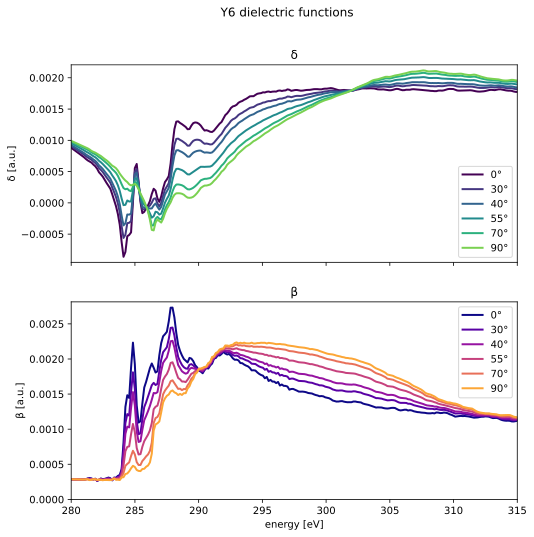

In [211]:
show_diel(280, 315, n_ep)

In [90]:
#save data to a txt file in a format that could be imported into CyRSoXS
#note that 0° is extraordinary and 90° is ordinary as those are the θ values where the measurement only perceives one or the other.
# the order of the columns is thus the order described below
np.savetxt('y6_extrap.txt',  np.c_[
    n_ep.energy, 
    n_ep.δ.sel(cos_sq_θ=1, method = 'nearest').values, #extraordinary, para
    n_ep.β.sel(cos_sq_θ=1, method = 'nearest').values, #extraordinary, para
    n_ep.δ.sel(cos_sq_θ=0, method = 'nearest').values, #ordinary, perp
    n_ep.β.sel(cos_sq_θ=0, method = 'nearest').values]) #ordinary, perp

/Users/andrew/conda_install/envs/data/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/andrew/conda_install/envs/data/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/andrew/conda_install/envs/data/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/andrew/conda_install/envs/data/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is de

## Extrapolating to a "molecular" dielectric function.
But there is more we can do. The molecules at the voxel level may not be limited to the orientation extremes measured on a whole-film basis. The whole film represents an ensemble and is likely never similar to what an individual molecule or voxel is capable of unless it is sigle crystal like highly oriented pyrolytic graphite (HOPG). To develop a "molecular" dielectric function, we must manipulate the NEXAFS beyond what was measured. 

This manipulation requires making an assumption about how one or more resonances should behave with energy; implicit in this assumption is typically an assumption about the conformation of the molecule.

For this exercise we will assume that the molecule Y6 has a rigid and planar conjugated structure, such that the pi* resonances should follow Stohr 9.16a for $\alpha=0$°


The function below develops a mean squared error for the area between e_min and e_max for a specific extrapolation of the nexafs curves, and a target area. The target area will be developed from our knowledge of how I should vary with $\alpha$ and $\theta$ described above.<br>
Note there is an additional contributor to mse below: if the extrapolation produces negative values for absorbance it imposes a stiff penalty because such values are unphysical.

In [212]:
def mse(cos_sq_θ, e_min, e_max, nexafs, nexafs_fit, targ):
    #compose new extrapolated nexafs based on proposed cos_sq_θ 
    nexafs_new = evaluate_nexafs_fit(nexafs, nexafs_fit, [cos_sq_θ[0]], [0])
    #evaluate the difference in area between the extrapolated nexafs and the taget targ
    mse = (int_area(e_min, e_max, nexafs_new)-targ)**2
    minval = nexafs_new.sel(energy = slice(e_min,e_max)).electron_yield.min().values
    if minval < 0: #impose penalty for negative absorbance values
        mse = 1E10*mse*(-minval)
    return mse

For our first fit, we will attempt to make the pi* manifold absorbance zero; this would correspond to $\alpha=0, \theta=90$°

In [223]:
#these are integration bounds; we will extrapolate to "perfect" values of integrated intensity within these bounds
#which bound you choose will adjust the result slightly.
e_min = 283
e_max = 285.3
res = optimize.differential_evolution(mse, [(-1, 1)], args = (e_min, e_max, nexafs, nexafs_fit, 0), tol=1e-6)
cos_sq_θ_mol_o = float(res.x)

For the next fit, we will attempt to make the pi* manifold maximized to correspond to $\alpha=0, \theta=0$°.<br> For a perfectly oriented $\alpha = 0$° molecule, the target would be exactly 3x the magic intensity. But our fit prefers some small amount of intensity so that absorbance doesn't go below zero. We will instead determine our target using the math above:<br><br>
$\displaystyle\frac{I(90) - I(54.7)}{I(0) - I(54.7)} = \frac{\frac{1}{3}[1+(3cos^2\alpha-1)]-\frac{1}{3}}{\frac{1}{3}[1-\frac{1}{2}(3cos^2\alpha-1)] - \frac{1}{3}} =-2$


In [224]:
magic_int = int_area(e_min, e_max, evaluate_nexafs_fit(nexafs, nexafs_fit, [0.329], [0]))
ord_int = int_area(e_min, e_max, evaluate_nexafs_fit(nexafs, nexafs_fit, [cos_sq_θ_mol_o], [0]))
e_targ = magic_int + 2*(magic_int-ord_int)
#For perfectly face on, the extraordinary intensity should be exactly 3x magic intensity
res = optimize.minimize(mse, 1, method='Nelder-Mead', args = (e_min, e_max, nexafs, nexafs_fit, e_targ), tol=1e-6)
cos_sq_θ_mol_e = float(res.x)

In [225]:
mol_fits = [cos_sq_θ_mol_e, cos_sq_θ_mol_o]

In [216]:
def forward(x):
    return np.arccos(np.sqrt(x)) * 180 / np.pi

In [229]:
mol_fits

[1.214257431030274, -0.11362870498676636]

In [230]:
forward(mol_fits)

/var/folders/m1/v62q73kx1ylgb2vpydrxbyy40000gn/T/ipykernel_77446/3585106248.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.arccos(np.sqrt(x)) * 180 / np.pi
/var/folders/m1/v62q73kx1ylgb2vpydrxbyy40000gn/T/ipykernel_77446/3585106248.py:2: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(np.sqrt(x)) * 180 / np.pi


array([nan, nan])

In [219]:
forward(nexafs.cos_sq_θ.values)

array([30., 40., 55., 70., 90.])

In [226]:
nexafs_mol = evaluate_nexafs_fit(nexafs, nexafs_fit, mol_fits, [0, 90])

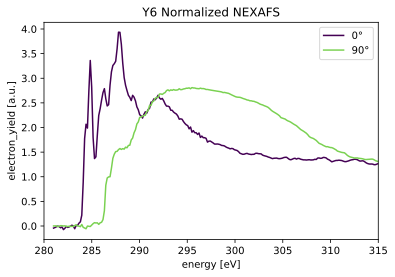

In [227]:
show_nexafs(280,315, nexafs_mol, save=True, savename=f'{sample}_nexafs_alpha_theta_extrap.svg')

The NEXAFS looks fairly reasonable with this extrapolation.<br><br>Calculate dielectric functions next:

In [358]:
n_mol = run_kkcalc_a(nexafs_mol, x_min = 280, x_max = 315, chemical_formula = 'C82H86F4N8O2S5', density = 1.1)

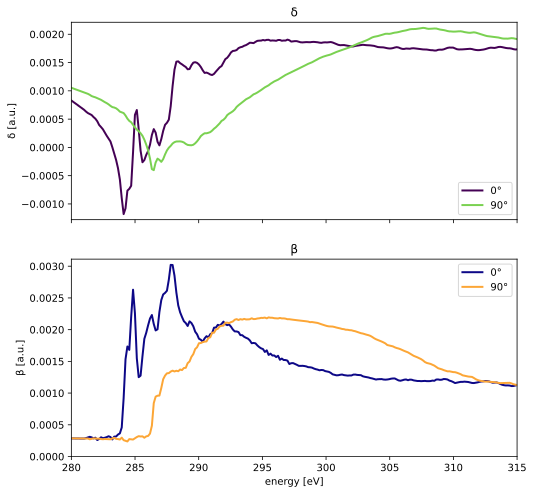

In [362]:
show_diel(280, 315, n_mol, save=True)

This is the dielectric function extrapolated to "perfect" molecular orientation.

In [99]:
#save data to a txt file in a format that could be imported into CyRSoXS
#note that 0° is extraordinary and 90° is ordinary as those are the θ values where the measurement only perceives one or the other.
# the order of the columns is thus the order described below
np.savetxt('y6_molecular.txt',  np.c_[
    n_mol.energy, 
    n_mol.δ.sel(cos_sq_θ=cos_sq_θ_mol_e, method = 'nearest').values, #extraordinary, para
    n_mol.β.sel(cos_sq_θ=cos_sq_θ_mol_e, method = 'nearest').values, #extraordinary, para
    n_mol.δ.sel(cos_sq_θ=cos_sq_θ_mol_o, method = 'nearest').values, #ordinary, perp
    n_mol.β.sel(cos_sq_θ=cos_sq_θ_mol_o, method = 'nearest').values]) #ordinary, perp

/Users/andrew/conda_install/envs/data/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/andrew/conda_install/envs/data/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/andrew/conda_install/envs/data/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/andrew/conda_install/envs/data/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is de

## Contrast: vacuum contrast vs. oriented manifold

Because the Y6 dielectric function is anisotropic, there is not a single vacuum contrast but rather a series of contrasts depending on the mixing of the ordinary and extraordinary dielectric function elements. Otherwise the calculation is identical to the calculation discussed in Part 1.

In [363]:
#this wrapper function is the same as described in Part 1
#this will accept and return xarrays
def binary_contrast(n1, n2=None):
    if n2 is None:
        #second component is vacuum
        n2 = xr.zeros_like(n1)
    else:
        #second is interpolated to match the energy array of the first component.  
        n2 = n2.interp(energy=n1.energy)
    return n1.energy**4 * ((n1.δ-n2.δ)**2 + (n1.β-n2.β)**2)

In [364]:
#develop a finely-divided list of extrapolation values between the limits we fitted to above
cos_sq_0_spread = np.linspace(cos_sq_θ_mol_e, cos_sq_θ_mol_o, 50)
#extrapolate across this finely-divided list of extrapolation values
nexafs_mol_spread = evaluate_nexafs_fit(nexafs, nexafs_fit, cos_sq_0_spread, cos_sq_0_spread)
#run kkcalc on each of the extrapolated functions
y6_mol_spread = run_kkcalc_a(nexafs_mol_spread, x_min = 280, x_max = 315, chemical_formula = 'C82H86F4N8O2S5', density = 1.1)
#calculate binary contrast for the ensemble. Note that xarray will automatically broadcast across cos_sq_0 without prompting
n_mol_vac_c = binary_contrast(y6_mol_spread)

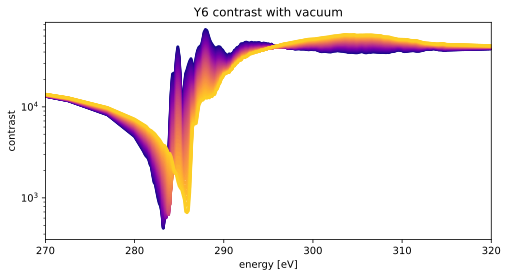

In [367]:
#plot the contrasts
xmin = 270
xmax = 320
fig, ax1 = plt.subplots(figsize=(8,4))
#xarray way of adding to a plot
colors = plt.cm.plasma(np.linspace(0,0.9,n_mol_vac_c.θ.size))
for i, cos_sq_θ in enumerate(n_mol_vac_c.cos_sq_θ): 
    n_mol_vac_c.sel(cos_sq_θ=cos_sq_θ).plot(color = colors[i], lw = 3)
ax1.set_xlim(xmin, xmax)
ymin = n_mol_vac_c.sel(energy=slice(xmin,xmax)).min()
ymax = n_mol_vac_c.sel(energy=slice(xmin,xmax)).max()
ax1.set_ylim(ymin*0.75,ymax*1.2)
ax1.set_yscale('log')
ax1.set_ylabel('contrast')
plt.title(f'{sample} contrast with vacuum')
plt.savefig(f'{sample}_vacuum_contrast.svg')
plt.show()
plt.close()

This envelope properly describes the possibilities for vacuum contrast with Y6.
# NEXAFS and anisotropic dielectric function for PM6
Repeat the process for PM6:

In [397]:
# pey= np.loadtxt(exportPath.joinpath('PM6_normed_nexafs.txt')).T

# # wrap in an xarray
# # we have a different array of angles here than for Y6

# θ_val = np.array([30, 40, 55, 70, 90])

# nexafs = xr.Dataset(
#     data_vars=dict(
#     electron_yield=(['cos_sq_θ', 'energy'], pey[1:])),
#     coords={'cos_sq_θ': np.cos(θ_val*np.pi/180)**2, 'θ': ('cos_sq_θ', θ_val), 'energy' : pey[0]},
#     attrs=dict(description='PM6 NEXAFS'),
# )
# nexafs.energy.attrs['unit'] = 'eV'
# nexafs['electron_yield'].attrs['unit'] = 'a.u.'
# nexafs['θ'].attrs['unit'] = '°'

In [403]:
sample = 'PM6'
nexafs = load_nexafs(exportPath.joinpath(f'{sample}_normed_nexafs.txt'), np.array([30,40,55,70,90]))

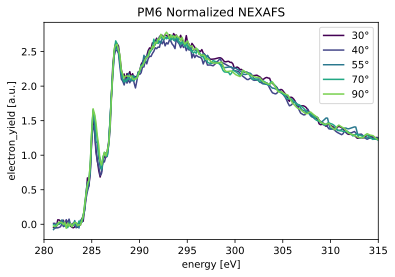

In [404]:
show_nexafs(280, 315, nexafs)

It is only subtly oriented. We can fit as before:

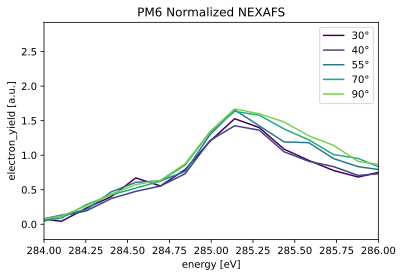

In [406]:
show_nexafs(284, 286, nexafs)

In [407]:
e_min = 284
e_max = 286
pi_peak_areas =  int_area(e_min, e_max, nexafs)
θ_list = θ_val

bnds= [(0,90),(0,10)]
res = optimize.differential_evolution(mse_line, bounds=bnds, args = (pi_peak_areas,θ_list) ,tol=1e-6)
print(res.x)

[58.46512339  4.78079051]


We find that there is a subtle "edge on" orientation with $\alpha=58.1$°<br>
We can run the same linear fit at each energy:

In [408]:
nexafs_fit = nexafs.electron_yield.polyfit('cos_sq_θ', 1)

We now must choose extrapolation targets. The consideration is different this time because this PM6 is preferentially edge on. It is not correct to "flip" a measured NEXAFS from edge to face because it is not possible to separate the 2 contributors to the ordinary axis. So we will extrapolate this NEXAFS to "perfect" edge on behavior. Thus for the extraordinary axis, we would expect zero pi* intensity:  

In [409]:
#these are integration bounds; we will extrapolate to "perfect" values of integrated intensity within these bounds
#which bound you choose will adjust the result slightly.
e_min = 284
e_max = 286
res = optimize.differential_evolution(mse, [(-5, 5)], args = (e_min, e_max, nexafs, nexafs_fit, 0), tol=1e-6)
cos_sq_θ_mol_e = float(res.x)

The ordinary axis intensity is once again guided by our distance relationship between magic and the extremes. In this case the difference is halved rather than doubled because we started with extraordinary rather than ordinary.

In [411]:
#For perfectly face on, the extraordinary intensity should be exactly 3x magic intensity
magic_int = int_area(e_min, e_max, evaluate_nexafs_fit(nexafs, nexafs_fit, [0.329], [0]))
extra_int = int_area(e_min, e_max, evaluate_nexafs_fit(nexafs, nexafs_fit, [cos_sq_θ_mol_e], [0]))

e_targ = magic_int + 0.5*(magic_int-ord_int)
res = optimize.minimize(mse, 1, method='Nelder-Mead', args = (e_min, e_max, nexafs, nexafs_fit, e_targ), tol=1e-6)
cos_sq_θ_mol_o = float(res.x)

In [412]:
mol_fits = [cos_sq_θ_mol_e, cos_sq_θ_mol_o]

In [413]:
nexafs_mol = evaluate_nexafs_fit(nexafs, nexafs_fit, mol_fits, [0, 90])

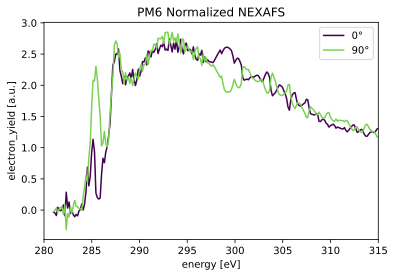

In [415]:
show_nexafs(280,315, nexafs_mol, save=True, savename=f'{sample}_alpha_theta_extrap.svg')

This also looks fairly reasonable! If we want a face-on dielectic function for PM6, it would be best to attempt to cast a film having this orientation and measure it.<br><br>
We can evaluate and save the PM6 edge-on dielectric function as follows:

In [416]:
#formula should be correct for Y6. density is a guess.
n_mol = run_kkcalc_a(nexafs_mol, x_min = 280, x_max = 315, chemical_formula = 'C68H76F2O2S8', density = 1.1)

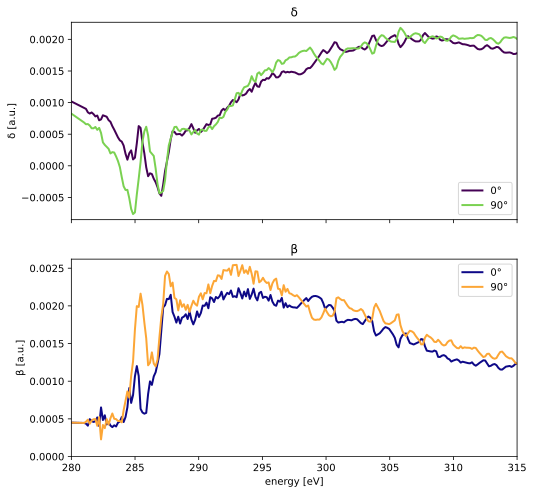

In [418]:
show_diel(280, 315, n_mol, save=True)

In [45]:
#save data to a txt file in a format that could be imported into CyRSoXS
#note that 0° is extraordinary and 90° is ordinary as those are the θ values where the measurement only perceives one or the other.
# the order of the columns is thus the order described below
np.savetxt('pm6_molecular.txt',  np.c_[
    n_ep.energy, 
    n_ep.δ.sel(cos_sq_θ=cos_sq_θ_mol_e, method = 'nearest').values, #extraordinary, para
    n_ep.β.sel(cos_sq_θ=cos_sq_θ_mol_e, method = 'nearest').values, #extraordinary, para
    n_ep.δ.sel(cos_sq_θ=cos_sq_θ_mol_o, method = 'nearest').values, #ordinary, perp
    n_ep.β.sel(cos_sq_θ=cos_sq_θ_mol_o, method = 'nearest').values]) #ordinary, perp

Just as before, run extrapolation finely divided within fit extremes. 

In [422]:
cos_sq_0_spread = np.linspace(cos_sq_θ_mol_e, cos_sq_θ_mol_o, 50)
pm6_mol_spread = evaluate_nexafs_fit(nexafs, nexafs_fit, cos_sq_0_spread, cos_sq_0_spread)
#guessing on PM6 density
pm6_mol_spread = run_kkcalc_a(pm6_mol_spread, x_min = 280, x_max = 315, chemical_formula = 'C68H76F2O2S8', density = 1.1)
#calculate binary contrast for the ensemble. Note that xarray will automatically broadcast across cos_sq_0 without prompting
n_mol_vac_c = binary_contrast(pm6_mol_spread)

This time, the contrast is <em>combinatorial</em> across the extrapolated values. In other words, any orientation of Y6 may scatter versus any orientation of PM6. We calculate the combintorial contrast below: 

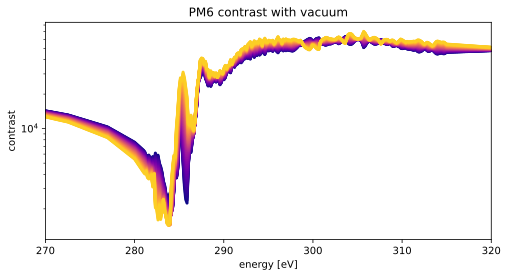

In [423]:
#plot the contrasts
xmin = 270
xmax = 320
fig, ax1 = plt.subplots(figsize=(8,4))
#xarray way of adding to a plot
colors = plt.cm.plasma(np.linspace(0,0.9,n_mol_vac_c.θ.size))
for i, cos_sq_θ in enumerate(n_mol_vac_c.cos_sq_θ): 
    n_mol_vac_c.sel(cos_sq_θ=cos_sq_θ).plot(color = colors[i], lw = 3)
ax1.set_xlim(xmin, xmax)
ymin = n_mol_vac_c.sel(energy=slice(xmin,xmax)).min()
ymax = n_mol_vac_c.sel(energy=slice(xmin,xmax)).max()
ax1.set_ylim(ymin*0.75,ymax*1.2)
ax1.set_yscale('log')
ax1.set_ylabel('contrast')
plt.title(f'{sample} contrast with vacuum')
plt.savefig(f'{sample}_vacuum_contrast.svg')
plt.show()
plt.close()

In [424]:
n_mol_c = []
for cos_sq_θ in y6_mol_spread.cos_sq_θ:
    n_mol_c.append(binary_contrast(y6_mol_spread.sel(cos_sq_θ=cos_sq_θ, method = 'nearest').drop('cos_sq_θ'), pm6_mol_spread))
n_mol_c = xr.concat(n_mol_c, 'cos_sq_θ_y6')

/Users/andrew/conda_install/envs/data/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/andrew/conda_install/envs/data/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/andrew/conda_install/envs/data/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/andrew/conda_install/envs/data/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing me

In [425]:
#this code finds the max and min of the combinatorial contrast at each energy.
c_max = n_mol_c.max('cos_sq_θ_y6')
c_max = c_max.max('cos_sq_θ')
c_min = n_mol_c.min('cos_sq_θ_y6')
c_min = c_min.min('cos_sq_θ')
c_magic = n_mol_c.sel(cos_sq_θ_y6=33).sel(cos_sq_θ=0.3333, method = 'nearest')

/Users/andrew/conda_install/envs/data/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


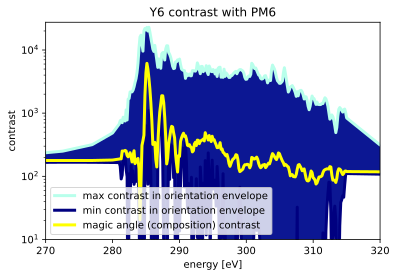

In [427]:
fig, ax1 = plt.subplots()
#xarray way of adding to a plot
# colors = plt.cm.plasma(np.linspace(0,1,n_mol_vac_c.θ.size))
c_max.plot(color = 'xkcd:pale aqua', lw = 3,label = 'max contrast in orientation envelope')
c_min.plot(color = 'navy', lw = 3, label = 'min contrast in orientation envelope')
c_magic.plot(color='yellow', lw = 3, label = 'magic angle (composition) contrast')
ax1.fill_between(c_max.energy.values, c_max.values, c_min.values, color = 'xkcd:royal')
ax1.set_xlim(xmin, xmax)
ymax = c_max.max()
ax1.set_ylim(10,ymax*1.2)
ax1.set_yscale('log')
ax1.set_ylabel('contrast')
plt.title('Y6 contrast with PM6')
plt.legend()
plt.show()

The combinatorial contrast is a function of both Y6 orientation and PM6 orientation. The variation with PM6 orientation is shown on the figure below. The variation with Y6 orientation is handled via slider.

In [430]:
from ipywidgets import interact, widgets, Layout

def f(y6_diel):
    fig, ax1 = plt.subplots()
    #xarray way of adding to a plot
    colors = plt.cm.plasma(np.linspace(0,1,n_mol_vac_c.θ.size))
    for j, cos_sq_θ in enumerate(n_mol_c.cos_sq_θ):
        n_mol_c.sel(cos_sq_θ_y6=y6_diel).sel(cos_sq_θ=cos_sq_θ).plot(color = colors[j], lw = 3)
    ax1.set_xlim(xmin, xmax)
    ymin = n_mol_c.sel(energy=slice(xmin,xmax)).min()
    ymax = n_mol_c.sel(energy=slice(xmin,xmax)).max()
    ax1.set_ylim(10,ymax*1.2)
    ax1.set_yscale('log')
    ax1.set_ylabel('contrast')
    plt.title('Y6 contrast with PM6')
    fig.canvas.draw()

interact(f, y6_diel=widgets.SelectionSlider(options=n_mol_c.cos_sq_θ_y6,value=n_mol_c.cos_sq_θ_y6.values[0],  layout=Layout(width='40%')))

interactive(children=(SelectionSlider(description='y6_diel', layout=Layout(width='40%'), options=(<xarray.Data…

<function __main__.f(y6_diel)>

What does this mean?

The two different representations above define the binary scattering contrasts that are <em>possible</em> in this PM6:Y6 blend, if we don't consider vacuum scattering. It's even broader if we do consider vacuum scattering! Any number of these traces, in any weighted combination, could contribute to the total scattering intensity (TSI) or "scattering invariant" that you measure in a PM6:Y6 system experimentally. 

A key takeaway is that it is essentially impossible to choose an energy at which the TSI will be dominated by <em>composition</em> with no orientation effects. This conclusion tends to be ignored in the analysis that is routinely done in OPV systems as measure of "relative phase purity." Going forward, it is important for the community to understand that orientation effects are likely present in these measurements, and there very likely scenarios where they <em>dominate</em> the response. Rather than being a "bad thing" for the technique, this conclusion emphasizes its unique sensitivity to molecular orientation. 

Frameworks to disentangle orientation effects from composition effects are under development. One demonstrated approach is to model data using the NIST RSoXS Simulation Suite:
https://github.com/usnistgov/nrss

...creating models that have both composition and orientation fluctuations and fitting those models to RSoXS data at several energies.
